# Philo
-------------------------------------------------------------
A small-scale cold gas VTVL rocket

In [149]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt

The goal of this notebook is to outline the process for determining the optimal parameters for a cold gas VTVL rocket. Rather than spending time and money iterating through different vehicle designs, we do some math to find the optimal parameters (ie - chamber pressure and temp, nozzle charactertics, etc) for our vehicle. Then perform a basic simulation using reasonable models (based on available parts in the market, ie - tanks, regulators, etc) to generate expected results.

### Assumptions
1. Isentropic Process
2. Ma = 1 at the throat of the nozzle (proof: [link here])}
3. Pb = 101.325kPa (Ambient Pressure)
4. Tb = 298.15K (Ambient Temperature)

### Initial Vehicle Model
1. Engine throat is the exit nozzle
2. Propellant: Air, cp = 0.846, cv = 0.657, gamma = 1.28
3. Dry mass        = 1.89kg
4. Propellant mass = 0.53kg

In [150]:
# Environment Properties
P_b = 101325             # Pa (Ambient Pressure)
T_b = 298.15             # K (Ambient Temperature)
R = 8.314                # J/(K*mol)
g = 9.81                 # m/s^2
Ma_t = 1                 # Mach (at throat)

# Propellant Properties 
cp = 1.005               # Constant pressure specific heat
cv = 0.718               # Constant volume specific heat
molar_mass = 0.02897     # kg/mol
gamma = cp/cv            # Specific Heat Ratio

# Vehicle Properties
dry_mass = 1.89                     # kg (rough estimation based on current design)
prop_mass = 0.53                    # kg (based on tank capacity and gas)
wet_mass = dry_mass + prop_mass     # kg

#### Step 0: Determine Theoretical Maximum Flight Time

This will be driven by our initial assumptions and initial vehicle model. With these parameters we can determine the theoretical maximum flight time using the rocket equation and by dividing the delta_V by gravity vector:

\begin{equation}
V_\Delta = V_e * ln\left(\frac{m_o}{m_f} \right)
\end{equation}

Where V_e_expected = 1000m/s 
(Based on Figure 2-5 from RPE - https://www.ewp.rpi.edu/hartford/~ernesto/S2013/EP/MaterialsforStudents/Lee/Sutton-Biblarz-Rocket_Propulsion_Elements.pdf)

In [151]:
v_e_expected = 1000   # m/s

delta_v = v_e_expected * np.log(wet_mass/dry_mass)

print ("Delta V: %0.2f m/s" % delta_v)

Delta V: 247.19 m/s


Divide by gravity vector to obtain flight time:

In [169]:
t_theoretical = delta_v / g

print ("Theoretical Flight Time: %0.2f sec" % t_theoretical)

Theoretical Flight Time: 25.20 sec



#### Step 1: Determine Choked Flow Parameters
Determine choked flow parameters:
> <b>KEY CONCEPTS: </b>
> * At choked flow, mass flow rate is <b>constant</b>
> * Since choked flow occurs at the throat of the nozzle, we base our equations relative to this plane. 
> * Choked flow occurs when the chamber pressure and temperature (stagnation pressure and temperature) reach their critical values.
> * To determine these critical values, we must use the critical ratios (a property of the propellant).
> * Thus choked flow is achieved when the chamber pressure (P_o) is greater than or equal to the critical pressure (P_*), and the chamber temperature (T_o) is greater than or equal to the critical temperature (T_*) respectively.

 Find the minimum chamber pressure (P_o) required to achieve choked flow and add margin 
 > Margin is added to compensate for regulator lag and to keep us safely in the choked flow region. If we break out of choked flow, our constant mass flow assumption no longer holds true, making the math much more complicated.

\begin{equation}
\frac{P_o}{P} = \left[1+\left(\frac{\gamma-1}{2}\right)Ma^2\right]^\frac{\gamma}{\gamma-1}
\end{equation}

\begin{equation}
\frac{T_o}{T} = 1+\left(\frac{\gamma-1}{2}\right)Ma^2
\end{equation}

Calculating at the throat where Ma = 1, we can now find the critical pressure and temperature:

\begin{equation}
\frac{P_o}{P_*} = \left[1+\left(\frac{\gamma-1}{2}\right)\right]^\frac{\gamma}{\gamma-1}
\end{equation}

\begin{equation}
\frac{T_o}{T_*} = 1+\left(\frac{\gamma-1}{2}\right)
\end{equation}

Since we know the flow is choked when the critical pressure (P_*) equals the back pressure (P_b), we can determine the minimum chamber pressure:

\begin{equation}
\frac{P_o}{P_b} = \left[1+\left(\frac{\gamma-1}{2}\right)\right]^\frac{\gamma}{\gamma-1}
\end{equation}

\begin{equation}
\frac{T_o}{T_b} = 1+\left(\frac{\gamma-1}{2}\right)
\end{equation}

\begin{equation}
c = \sqrt{\frac{\gamma R T}{m_{molar}}}
\end{equation}

\begin{equation}
M_a = \sqrt{\frac{2}{\gamma-1}\left(\left(\frac{P_{in}}{P_{out}}\right)^\frac{\gamma-1}{\gamma}-1\right)}
\end{equation}

\begin{equation}
v = M_ac
\end{equation}

In [170]:
# Chamber Properties
P_o_min = P_b*(((1+((gamma-1)/2)*(Ma_t**2))**(gamma/(gamma-1))))
T_o_min = T_b*(1+(((gamma-1)/2)*(Ma_t)))

Ma_t

V_ee = Ma_t*np.sqrt((gamma*R*T_b)/molar_mass)

print ("V_e: %0.2f m/s" % V_ee)
print ("Choked Flow:")
print ("Minimum Chamber Pressure: %.2f Pa" % P_o_min)
print ("Minimum Chamber Temperature: %.2f K" % T_o_min)

V_e: 346.07 m/s
Choked Flow:
Minimum Chamber Pressure: 191784.01 Pa
Minimum Chamber Temperature: 357.74 K


TODO: Ara - reword and clean up below

#### Step 2: Determine Exit Velocity at Nozzle

Now that we know the the minimum chamber pressure and temperature, we can calculate the expected minimum exit velocity at the nozzle (V_e_min) using the following equation:

\begin{equation}
V_e = \sqrt{\frac{T_b R}{m_{molar}}*\frac{2 \gamma}{\gamma-1}*\left(1-\left(\frac{P_b}{P_o}\right)^{\frac{\gamma-1}{\gamma}}\right)}
\end{equation}

In [154]:
V_e_min = np.sqrt(((T_b * R) / molar_mass) \
      * ((2 * gamma) / (gamma - 1)) \
      * (1 - (P_b / P_o_min) ** (
        (gamma - 1) / gamma)))

Isp_min = V_e_min / g

print ("Minimum Exit Velocity at Nozzle: %.2f m/s" % V_e_min)
print ("Minimum Specific Impulse: %2f sec" % Isp_min)

Minimum Exit Velocity at Nozzle: 315.94 m/s
Minimum Specific Impulse: 32.205834 sec


#### Step 3: Determine Cross-Sectional Area at the Throat of the Nozzle

Next we need to determine the cross-sectional area of the throat. However, before we proceed, we must first select our desired nominal thrust then solve for the mass flow rate using the following equation:

\begin{equation}
F = \dot{m}*V_e
\end{equation}

Rewritten as:

\begin{equation}
\dot{m} = \frac{F}{V_e}
\end{equation}

In order to determine the desired nominal thrust, we must calcuate the force necessary to null out the acceleration of a fully loaded rocket:

\begin{equation}
F_{nominal} = m_{wet} * g
\end{equation}

Of course, this force will change as the rocket loses mass, but it gives us a place to start.

In [155]:
F_nom = wet_mass * g

print ("Nominal Engine Thrust: %.2f N" % F_nom)

Nominal Engine Thrust: 23.74 N


With a nominal thrust, we can now work out a rough cross-sectional area at the throat.

In [156]:
mass_flow = F_nom / V_e_min         # kg/s

print ("Mass Flow Rate: %.6f kg/s" % mass_flow)

Mass Flow Rate: 0.075142 kg/s


With a known mass flow rate, we can now determine the cross-sectional area at the throat using the following equation:
    
\begin{equation}
A = \frac{\dot{m}* \left(1+(\gamma-1)\frac{M_a^2}{2}\right)^\frac{\gamma+1}{2(\gamma-1)}}{M_a P_o\sqrt{\frac{\gamma}{R T_o}}}
\end{equation}

Since we are solving for the area at the throat of the nozzle: \begin{equation} M_a = 1 \end{equation}

In [157]:
Ma = 1                             # Mach Number
A_t = (mass_flow*(1+(gamma-1)*((Ma**2)/2))**((gamma+1)/(2*(gamma-1))))/(Ma*P_o_min*np.sqrt(gamma/(R*T_o_min)))

print ("Cross-sectional Area at Throat: %.8f m^2" % A_t)
print ("Cross-sectional Area at Throat: %.2f mm^2" % (A_t*1e6))

print ("Throat Diameter: %.2f mm" % (2*(np.sqrt((A_t*1e6)/np.pi))) )

Cross-sectional Area at Throat: 0.00003121 m^2
Cross-sectional Area at Throat: 31.21 mm^2
Throat Diameter: 6.30 mm


#### Step 4: Determine Flight Time

We can now obtain a ballpark estimate of flight time by dividing the total propellant mass by mass flow rate

\begin{equation}
t_{flight} = \frac{m_{prop}}{\dot{m}}
\end{equation}

In [158]:
t_flight = prop_mass / mass_flow    # sec

print ("Time of Flight: %0.2f sec" % t_flight)

Time of Flight: 7.05 sec


#### Step 5: Optimize for Flight Time

Not a very impressive flight time, but now we have a starting point, and there's plenty of room to optimize...

Now that we know the minimum values for choked flow while producing the necessary force to null out vertical acceleration of the vehicle, we can figure out which knobs to tune to optimize for flight time while checking/validating that we are still at choked flow. 
<br><br>
Flight time optimization goals:
1. Increase P_o to increase V_e and decrease mass flow rate and A thus increasing flight time.
3. Optimization shall check choke flow model for compliance
<br><br>

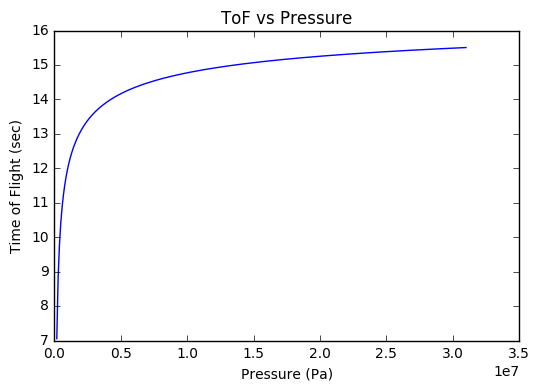

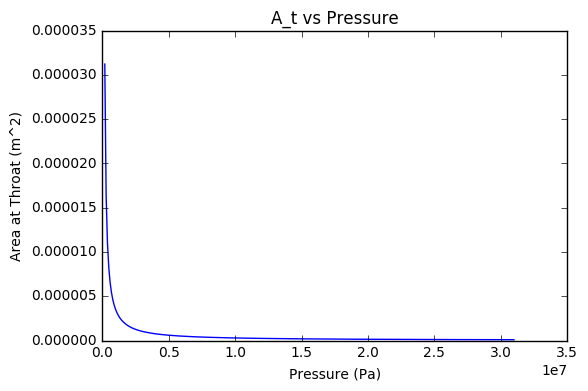

In [159]:
# Time of Flight vs Chamber Pressure

def calc_engine(P_o):    
    V_e_min = np.sqrt(((T_b * R) / molar_mass) \
      * ((2 * gamma) / (gamma - 1)) \
      * (1 - (P_b / P_o) ** (
        (gamma - 1) / gamma)))

    Isp_min = V_e_min / g
    
    F_nom = wet_mass * g    
    
    mass_flow = F_nom / V_e_min         # kg/s    
    
    Ma = 1                              # Mach Number
    A_t = (mass_flow*(1+(gamma-1)*((Ma**2)/2))**((gamma+1)/(2*(gamma-1))))/(Ma*P_o*np.sqrt(gamma/(R*T_o_min)))
    
    t_flight = prop_mass / mass_flow    # sec
    
    return t_flight, A_t

# p_o_min calculated above
p_step = 100000
P_tank_max = 3.1026e+7

# Sweep the pressure and plot the time of flight
p_array = np.arange(int(P_o_min), int(P_tank_max), p_step)
ToF_array, At_array = calc_engine(p_array)

plt.figure(1)
plt.xlabel('Pressure (Pa)')
plt.ylabel('Time of Flight (sec)')
plt.title('ToF vs Pressure')
plt.plot(p_array, ToF_array)

plt.figure(2)
plt.xlabel('Pressure (Pa)')
plt.ylabel('Area at Throat (m^2)')
plt.title('A_t vs Pressure')
plt.plot(p_array, At_array)
plt.show()

As expected, we asymptote near a theoretical ToF limit near 16-17 seconds

Why is this not value not 25 seconds? <br>
Because we initially guessed a V_e limit of 1000 m/s based on a reference table, these results more accurately reflect the expected time of flight based on our vehicle model. However, our results are in family with the reference materal, so we can feel a little more confident with them.

Here's yet another step where the engineer gets to decide a value.. what nominal chamber pressure shall we go with?

First lets analyze what this graph is telling us:
> - As pressure increases, time of flight increases
> - We observe larger variations in time of flight as a function of error in pressure at lower pressures
> - At higher pressures, the gains in time of flight are very small

What we know about the real world and our rocket:
> - The higher the pressure, the more mass and complexity there is for measuring and controlling it
> - Tooling limitations: We can only make the throat of the nozzle so small
> - Mass is our enemy: The more mass we can shed, the greater our flight time

In [160]:
# Pick P_o, A_t, Time of Flight
P_o = 0.1e7 # Pa (~145psi) [TODO: EXPLAIN THIS CHOICE]

ToF, A_t = calc_engine(P_o)

print ("Selected ToF: %0.2f sec" % ToF)
print ("Selected A_t: %0.8f m^2" % A_t)
print ("Selected A_t: %.2f mm^2" % (A_t*1e6))
print ("Selected Throat Diameter: %.2f mm" % (2*(np.sqrt((A_t*1e6)/np.pi))) )

Selected ToF: 11.97 sec
Selected A_t: 0.00000353 m^2
Selected A_t: 3.53 mm^2
Selected Throat Diameter: 2.12 mm


Select desired exit velocity: M_e (in mach)

In [161]:
# Desired Exit Velocity (in Mach)
Ma_e = 2 # This isn't right, update

#### Step 6: Further Optimize by Adding an Exit Nozzle

Up until this point we've been assuming that the throat is the exit nozzle. The next step is to add an expansion at the end of the throat to maximize V_e (as per De Laval). The key to this is determining the desired area at the throat (see above) and calculating the area at the exit of the nozzle. Thankfully, this math isn't too bad. The Ae/At ratio is a direct function of the propellant chemical properties:

\begin{equation}
\frac{A_e}{A_t} = \frac{1}{M_e}\left[ \left(\frac{2}{\gamma+1}\right)\left(1 + \frac{\gamma-1}{2}M_e^2\right) \right]^\frac{\gamma+1}{2(\gamma-1)}
\end{equation}

Since we already know A_t, we can now solve for A_e:

\begin{equation}
A_e = \frac{A_t}{M_e}\left[ \left(\frac{2}{\gamma+1}\right)\left(1 + \frac{\gamma-1}{2}M_e^2\right) \right]^\frac{\gamma+1}{2(\gamma-1)}
\end{equation}

In [162]:
A_e = (A_t/Ma_e)*(((2/(gamma+1))*(1+((gamma-1)/2)*(Ma_e**2)))**((gamma+1)/(2*(gamma-1))))

print ("Area at Exit: %0.8f m^2" % A_e)
print ("Area at Exit: %.2f mm^2" % (A_e*1e6))
print ("Selected Exit Diameter: %.2f mm \n" % (2*(np.sqrt((A_e*1e6)/np.pi))) )

# Ae/At Ratio
A_e_A_t = A_e / A_t
print ("Ae/At Ratio: %0.2f" % A_e_A_t)

Area at Exit: 0.00000595 m^2
Area at Exit: 5.95 mm^2
Selected Exit Diameter: 2.75 mm 

Ae/At Ratio: 1.69


TODO: Recalculte ToF based on new V_e<br>
TODO: Include \begin{equation} F = \dot{m}*V_e + A_e(P_e - P_{atm}) \end{equation}